In [1]:
# --- CELL 1: THI·∫æT L·∫¨P V√Ä IMPORT TH∆Ø VI·ªÜN ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os

# T·∫Øt c√°c c·∫£nh b√°o kh√¥ng c·∫ßn thi·∫øt
warnings.filterwarnings("ignore")

# --- Th∆∞ vi·ªán cho c√°c m√¥ h√¨nh ---
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from neuralforecast.models import NHITS
from neuralforecast.core import NeuralForecast

# Thi·∫øt l·∫≠p style cho bi·ªÉu ƒë·ªì
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
print("‚úÖ T·∫•t c·∫£ th∆∞ vi·ªán ƒë√£ ƒë∆∞·ª£c import th√†nh c√¥ng!")

2025-06-11 20:49:28,750	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-11 20:49:29,098	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


‚úÖ T·∫•t c·∫£ th∆∞ vi·ªán ƒë√£ ƒë∆∞·ª£c import th√†nh c√¥ng!


In [2]:
# --- CELL 2: ƒê·ªåC V√Ä T·ªîNG H·ª¢P D·ªÆ LI·ªÜU T·ª™ FILE TH√î (ƒê√É S·ª¨A L·ªñI) ---

# --- Vui l√≤ng thay ƒë·ªïi c√°c ƒë∆∞·ªùng d·∫´n file ·ªü ƒë√¢y ---
raw_file_path = r"C:\Users\nguye\CODE\TimeSeries\BTL\Data\Time_Data.csv"
aggregated_parquet_path = 'aggregated_final_data.parquet'
# ----------------------------------------------------

if os.path.exists(aggregated_parquet_path):
    print(f"Ph√°t hi·ªán file ƒë√£ t·ªïng h·ª£p '{aggregated_parquet_path}'. ƒêang ƒë·ªçc tr·ª±c ti·∫øp...")
    df_agg_final = pd.read_parquet(aggregated_parquet_path)
    print("‚úÖ ƒê·ªçc file ƒë√£ t·ªïng h·ª£p th√†nh c√¥ng!")

else:
    print("Kh√¥ng t√¨m th·∫•y file ƒë√£ t·ªïng h·ª£p. B·∫Øt ƒë·∫ßu x·ª≠ l√Ω l·∫°i t·ª´ file CSV 50GB...")
    chunks = pd.read_csv(raw_file_path, chunksize=10000000)
    all_chunks = []

    print("B·∫Øt ƒë·∫ßu t·ªïng h·ª£p d·ªØ li·ªáu theo user_id v√† th√°ng...")
    for chunk in tqdm(chunks):
        chunk['event_time'] = pd.to_datetime(chunk['event_time'])
        chunk['month'] = chunk['event_time'].dt.to_period('M').astype(str)
        
        agg = chunk.groupby(['user_id', 'month']).agg(
            event_count=('event_time', 'count'),
            total_spent=('price', 'sum'),
            purchase_count=('event_type', lambda x: (x == 'purchase').sum()),
            n_categories=('category_code', 'nunique'),
            churn=('churn', 'max')
        ).reset_index()
        
        all_chunks.append(agg)

    print("ƒêang g·ªôp c√°c chunk ƒë√£ x·ª≠ l√Ω...")
    df_to_agg = pd.concat(all_chunks)

    # PH·∫¶N S·ª¨A L·ªñI QUAN TR·ªåNG NH·∫§T: Ch·ªâ ƒë·ªãnh r√µ c√°ch t·ªïng h·ª£p cho t·ª´ng c·ªôt
    final_aggregation_rules = {
        'event_count': 'sum',
        'total_spent': 'sum',
        'purchase_count': 'sum',
        'n_categories': 'sum',
        'churn': 'max' # Quan tr·ªçng: Ch·ªâ l·∫•y gi√° tr·ªã l·ªõn nh·∫•t (0 ho·∫∑c 1)
    }
    
    df_agg_final = df_to_agg.groupby(['user_id', 'month']).agg(final_aggregation_rules).reset_index()
    
    df_agg_final.to_parquet(aggregated_parquet_path)
    print(f"‚úÖ D·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c t·ªïng h·ª£p ƒê√öNG C√ÅCH v√† l∆∞u v√†o '{aggregated_parquet_path}'.")

# Hi·ªÉn th·ªã k·∫øt qu·∫£ ƒë·ªÉ ki·ªÉm tra
print("\n--- 5 D√íNG ƒê·∫¶U TI√äN C·ª¶A D·ªÆ LI·ªÜU SAU KHI T·ªîNG H·ª¢P ---")
print(df_agg_final.head())
print(f"\nKi·ªÉm tra c√°c gi√° tr·ªã duy nh·∫•t trong c·ªôt 'churn' sau khi t·ªïng h·ª£p:")
print(df_agg_final['churn'].unique())

Kh√¥ng t√¨m th·∫•y file ƒë√£ t·ªïng h·ª£p. B·∫Øt ƒë·∫ßu x·ª≠ l√Ω l·∫°i t·ª´ file CSV 50GB...
B·∫Øt ƒë·∫ßu t·ªïng h·ª£p d·ªØ li·ªáu theo user_id v√† th√°ng...


35it [1:22:18, 141.10s/it]


ƒêang g·ªôp c√°c chunk ƒë√£ x·ª≠ l√Ω...
‚úÖ D·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c t·ªïng h·ª£p ƒê√öNG C√ÅCH v√† l∆∞u v√†o 'aggregated_final_data.parquet'.

--- 5 D√íNG ƒê·∫¶U TI√äN C·ª¶A D·ªÆ LI·ªÜU SAU KHI T·ªîNG H·ª¢P ---
    user_id    month  event_count  total_spent  purchase_count  n_categories  \
0  10300217  2019-11            1        40.54               0             0   
1  12511517  2020-02            1       100.39               0             1   
2  12511517  2020-03            1        17.63               0             1   
3  22165363  2020-01            2       507.10               0             2   
4  22165363  2020-02           10       991.38               0             5   

   churn  
0      1  
1      1  
2      1  
3      1  
4      1  

Ki·ªÉm tra c√°c gi√° tr·ªã duy nh·∫•t trong c·ªôt 'churn' sau khi t·ªïng h·ª£p:
[1 0]


In [3]:
# --- CELL 3: TI·ªÄN X·ª¨ L√ù D·ªÆ LI·ªÜU ƒê√É T·ªîNG H·ª¢P ---

print("B·∫Øt ƒë·∫ßu ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu ƒë√£ t·ªïng h·ª£p...")
df_processed = df_agg_final.copy()

# 1. Chuy·ªÉn ƒë·ªïi c·ªôt 'month' sang ƒë·ªãnh d·∫°ng datetime
df_processed['month'] = pd.to_datetime(df_processed['month'])

# 2. Ki·ªÉm tra v√† x·ª≠ l√Ω d·ªØ li·ªáu thi·∫øu (n·∫øu c√≥)
print("\nKi·ªÉm tra d·ªØ li·ªáu thi·∫øu:")
print(df_processed.isnull().sum())

# 3. S·∫Øp x·∫øp d·ªØ li·ªáu theo user v√† th·ªùi gian
df_processed = df_processed.sort_values(by=['user_id', 'month']).reset_index(drop=True)

print("\n‚úÖ Ti·ªÅn x·ª≠ l√Ω ho√†n t·∫•t. D·ªØ li·ªáu ƒë√£ s·∫µn s√†ng cho m√¥ h√¨nh.")

B·∫Øt ƒë·∫ßu ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu ƒë√£ t·ªïng h·ª£p...

Ki·ªÉm tra d·ªØ li·ªáu thi·∫øu:
user_id           0
month             0
event_count       0
total_spent       0
purchase_count    0
n_categories      0
churn             0
dtype: int64

‚úÖ Ti·ªÅn x·ª≠ l√Ω ho√†n t·∫•t. D·ªØ li·ªáu ƒë√£ s·∫µn s√†ng cho m√¥ h√¨nh.


B·∫Øt ƒë·∫ßu tr·ª±c quan h√≥a d·ªØ li·ªáu...


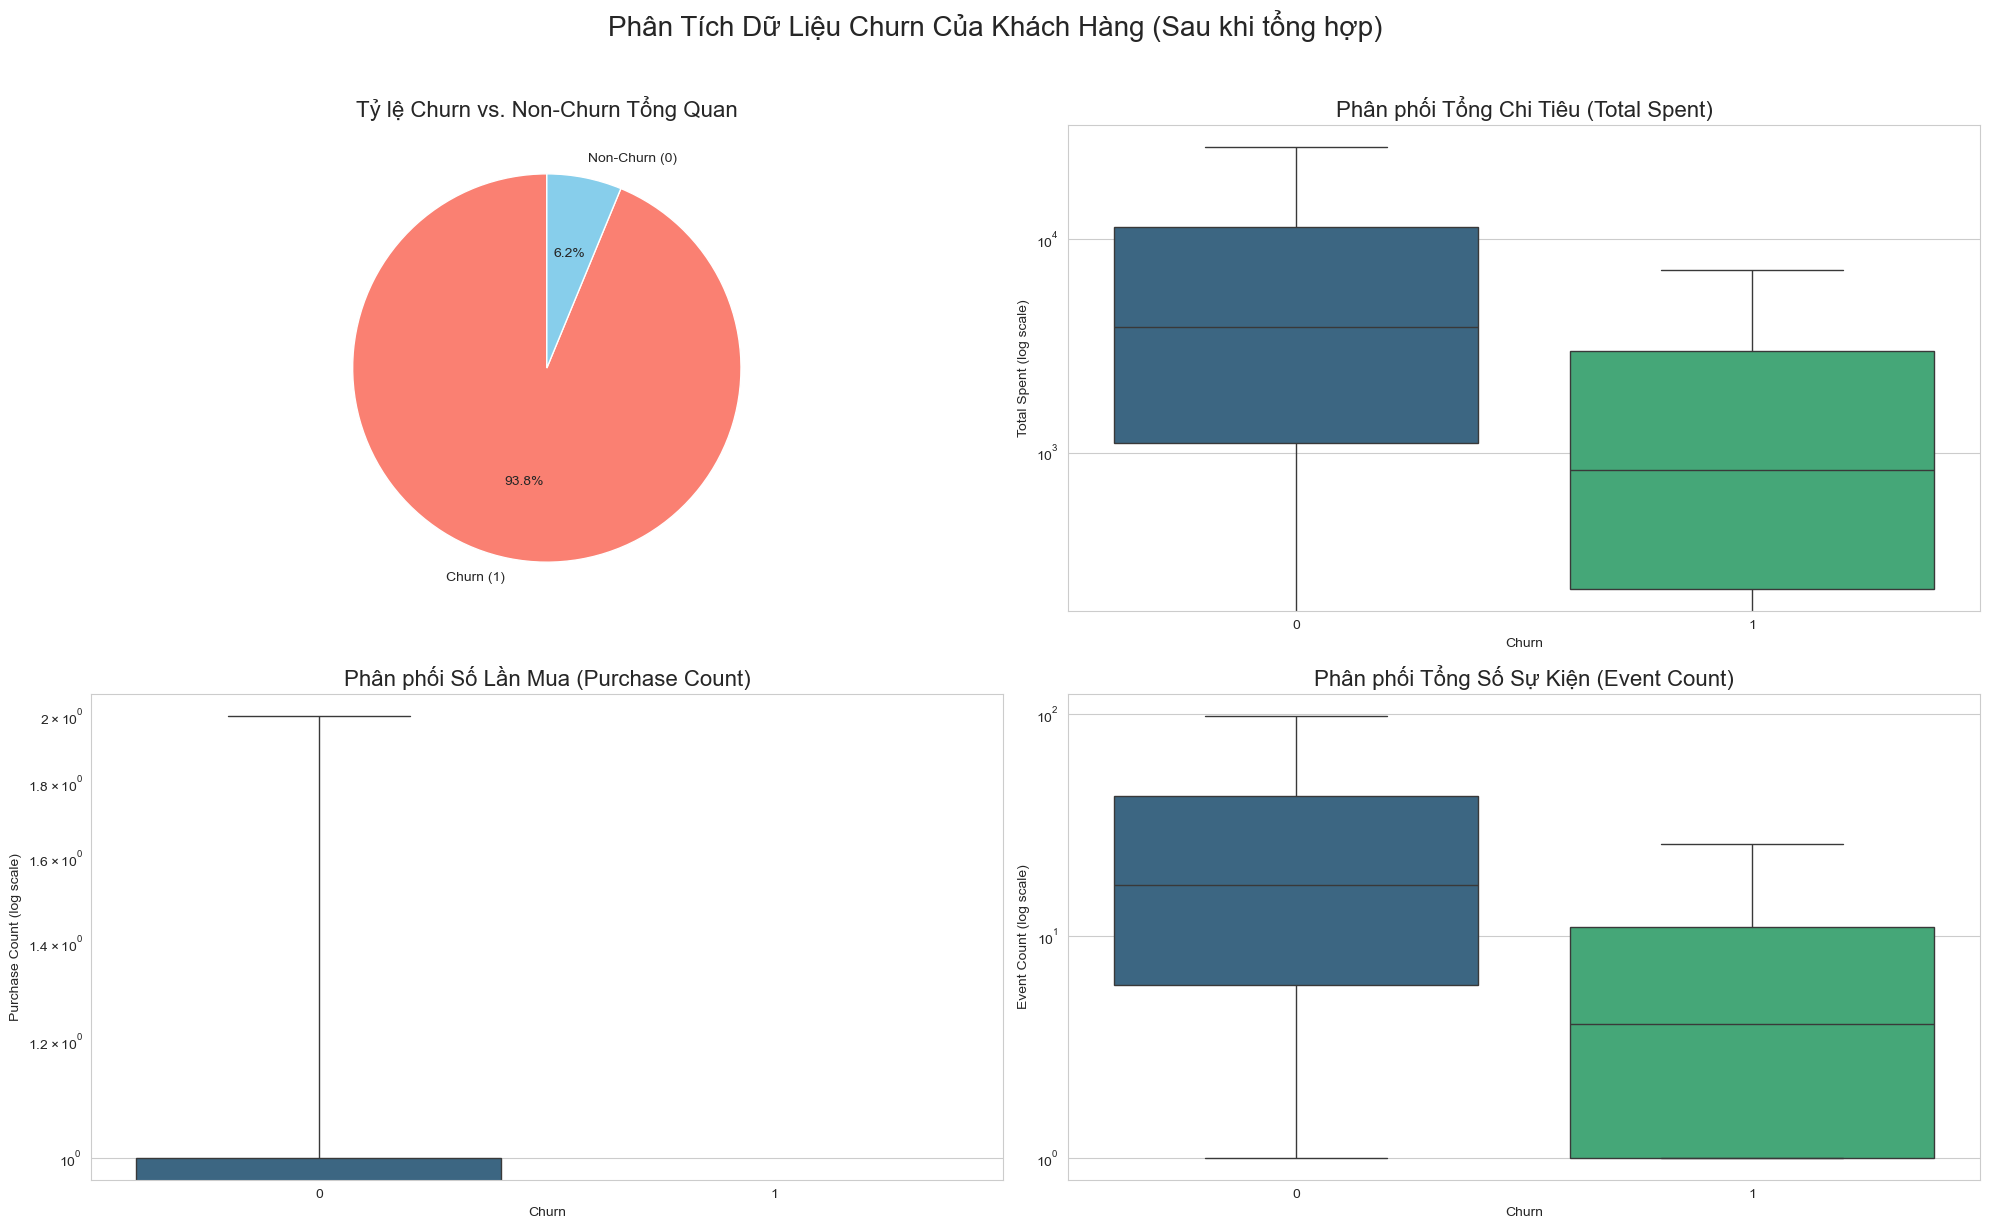

In [4]:
# --- CELL 4: PH√ÇN T√çCH V√Ä TR·ª∞C QUAN H√ìA D·ªÆ LI·ªÜU (EDA) (ƒê√É S·ª¨A L·ªñI) ---

print("B·∫Øt ƒë·∫ßu tr·ª±c quan h√≥a d·ªØ li·ªáu...")

plt.figure(figsize=(20, 12))
plt.suptitle("Ph√¢n T√≠ch D·ªØ Li·ªáu Churn C·ªßa Kh√°ch H√†ng (Sau khi t·ªïng h·ª£p)", fontsize=20, y=1.02)

# 1. Ph√¢n ph·ªëi c·ªßa nh√£n Churn (Code m·ªõi, an to√†n h∆°n)
plt.subplot(2, 2, 1)
churn_counts = df_processed['churn'].value_counts()

# T·∫°o nh√£n v√† m√†u s·∫Øc ƒë·ªông d·ª±a tr√™n d·ªØ li·ªáu th·ª±c t·∫ø
label_map = {0: 'Non-Churn (0)', 1: 'Churn (1)'}
color_map = {0: 'skyblue', 1: 'salmon'}
dynamic_labels = churn_counts.index.map(lambda x: label_map.get(x, str(x)))
dynamic_colors = churn_counts.index.map(lambda x: color_map.get(x, 'gray'))

if not churn_counts.empty:
    plt.pie(churn_counts, labels=dynamic_labels, colors=dynamic_colors, autopct='%1.1f%%', startangle=90)
    plt.title('T·ª∑ l·ªá Churn vs. Non-Churn T·ªïng Quan', fontsize=16)
else:
    plt.text(0.5, 0.5, 'Kh√¥ng c√≥ d·ªØ li·ªáu Churn', ha='center', va='center')
    plt.title('Kh√¥ng c√≥ d·ªØ li·ªáu Churn', fontsize=16)
plt.ylabel('')

# 2. Ph√¢n ph·ªëi 'total_spent' theo churn
plt.subplot(2, 2, 2)
sns.boxplot(data=df_processed, x='churn', y='total_spent', showfliers=False, palette='viridis')
plt.title('Ph√¢n ph·ªëi T·ªïng Chi Ti√™u (Total Spent)', fontsize=16)
plt.yscale('log')
plt.xlabel('Churn')
plt.ylabel('Total Spent (log scale)')

# 3. Ph√¢n ph·ªëi 'purchase_count' theo churn
plt.subplot(2, 2, 3)
sns.boxplot(data=df_processed, x='churn', y='purchase_count', showfliers=False, palette='viridis')
plt.title('Ph√¢n ph·ªëi S·ªë L·∫ßn Mua (Purchase Count)', fontsize=16)
plt.yscale('log')
plt.xlabel('Churn')
plt.ylabel('Purchase Count (log scale)')

# 4. Ph√¢n ph·ªëi 'event_count' theo churn
plt.subplot(2, 2, 4)
sns.boxplot(data=df_processed, x='churn', y='event_count', showfliers=False, palette='viridis')
plt.title('Ph√¢n ph·ªëi T·ªïng S·ªë S·ª± Ki·ªán (Event Count)', fontsize=16)
plt.yscale('log')
plt.xlabel('Churn')
plt.ylabel('Event Count (log scale)')

plt.tight_layout()
plt.show()

In [5]:
# --- CELL 5: CHIA D·ªÆ LI·ªÜU TRAIN/TEST ---

print("Chia d·ªØ li·ªáu theo th·ªùi gian...")
last_month = df_processed['month'].max()
print(f"Th√°ng cu·ªëi c√πng trong d·ªØ li·ªáu (s·∫Ω ƒë∆∞·ª£c d√πng l√†m t·∫≠p test): {last_month.strftime('%Y-%m')}")

train_df = df_processed[df_processed['month'] < last_month]
test_df = df_processed[df_processed['month'] == last_month]

features = ['event_count', 'total_spent', 'purchase_count', 'n_categories']
target = 'churn'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print(f"\nK√≠ch th∆∞·ªõc t·∫≠p hu·∫•n luy·ªán (Train): {X_train.shape}")
print(f"K√≠ch th∆∞·ªõc t·∫≠p ki·ªÉm th·ª≠ (Test): {X_test.shape}")
if not y_test.empty:
    print(f"T·ª∑ l·ªá churn trong t·∫≠p test: {y_test.value_counts(normalize=True).get(1, 0):.2%}")
else:
    print("C·∫¢NH B√ÅO: T·∫≠p test r·ªóng, vui l√≤ng ki·ªÉm tra l·∫°i d·ªØ li·ªáu ho·∫∑c logic chia.")

Chia d·ªØ li·ªáu theo th·ªùi gian...
Th√°ng cu·ªëi c√πng trong d·ªØ li·ªáu (s·∫Ω ƒë∆∞·ª£c d√πng l√†m t·∫≠p test): 2020-03

K√≠ch th∆∞·ªõc t·∫≠p hu·∫•n luy·ªán (Train): (19914830, 4)
K√≠ch th∆∞·ªõc t·∫≠p ki·ªÉm th·ª≠ (Test): (4114060, 4)
T·ª∑ l·ªá churn trong t·∫≠p test: 94.16%


B·∫Øt ƒë·∫ßu hu·∫•n luy·ªán m√¥ h√¨nh XGBoost...
‚úÖ Hu·∫•n luy·ªán XGBoost ho√†n t·∫•t.

--- üìä K·∫æT QU·∫¢ XGBOOST ---
               precision    recall  f1-score   support

Non-Churn (0)       0.14      0.63      0.22    240172
    Churn (1)       0.97      0.75      0.85   3873888

     accuracy                           0.74   4114060
    macro avg       0.55      0.69      0.53   4114060
 weighted avg       0.92      0.74      0.81   4114060

üöÄ F1-Score: 0.8469
üöÄ ROC AUC Score: 0.7540


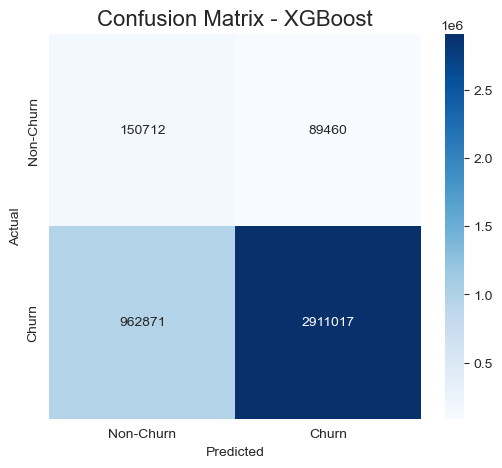

In [6]:
# --- CELL 6: HU·∫§N LUY·ªÜN V√Ä ƒê√ÅNH GI√Å XGBOOST ---

print("B·∫Øt ƒë·∫ßu hu·∫•n luy·ªán m√¥ h√¨nh XGBoost...")

if 1 in y_train.value_counts() and y_train.value_counts()[1] > 0:
    ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
else:
    ratio = 1 # Tr∆∞·ªùng h·ª£p an to√†n n·∫øu kh√¥ng c√≥ class 1

xgb_model = XGBClassifier(
    objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
    scale_pos_weight=ratio, n_estimators=200, learning_rate=0.05,
    max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42
)

xgb_model.fit(X_train, y_train, verbose=False)
print("‚úÖ Hu·∫•n luy·ªán XGBoost ho√†n t·∫•t.")

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n--- üìä K·∫æT QU·∫¢ XGBOOST ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Non-Churn (0)', 'Churn (1)']))
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
print(f"üöÄ F1-Score: {f1_xgb:.4f}")
print(f"üöÄ ROC AUC Score: {roc_auc_xgb:.4f}")

plt.figure(figsize=(6, 5))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
plt.title('Confusion Matrix - XGBoost', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [7]:
# --- CELL 7: CHU·∫®N B·ªä D·ªÆ LI·ªÜU D·∫†NG CHU·ªñI (SEQUENCE) ---

print("T·∫°o d·ªØ li·ªáu chu·ªói cho c√°c m√¥ h√¨nh Deep Learning...")

def create_sequences(df, features, target, sequence_length=3):
    X_seq, y_seq = [], []
    user_groups = df.groupby('user_id')
    
    print("T·∫°o sequence cho t·ª´ng user...")
    for user_id, group in tqdm(user_groups):
        data = group[features].values
        labels = group[target].values
        if len(data) > sequence_length:
            for i in range(len(data) - sequence_length):
                X_seq.append(data[i:i+sequence_length])
                y_seq.append(labels[i+sequence_length])
            
    return np.array(X_seq), np.array(y_seq)

SEQUENCE_LENGTH = 3 
X_seq, y_seq = create_sequences(df_processed, features, target, sequence_length=SEQUENCE_LENGTH)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

print(f"\n‚úÖ D·ªØ li·ªáu chu·ªói ƒë√£ t·∫°o xong!")
print(f"K√≠ch th∆∞·ªõc X_train_seq: {X_train_seq.shape}")
print(f"K√≠ch th∆∞·ªõc X_test_seq: {X_test_seq.shape}")

T·∫°o d·ªØ li·ªáu chu·ªói cho c√°c m√¥ h√¨nh Deep Learning...
T·∫°o sequence cho t·ª´ng user...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13529831/13529831 [6:50:42<00:00, 549.04it/s]    



‚úÖ D·ªØ li·ªáu chu·ªói ƒë√£ t·∫°o xong!
K√≠ch th∆∞·ªõc X_train_seq: (2077704, 3, 4)
K√≠ch th∆∞·ªõc X_test_seq: (519427, 3, 4)


B·∫Øt ƒë·∫ßu hu·∫•n luy·ªán LSTM tr√™n thi·∫øt b·ªã: CPU...
Epoch [1/5], Loss: 0.3781
Epoch [2/5], Loss: 0.3751
Epoch [3/5], Loss: 0.3733
Epoch [4/5], Loss: 0.3716
Epoch [5/5], Loss: 0.3700

ƒê√°nh gi√° m√¥ h√¨nh LSTM...

--- üìä K·∫æT QU·∫¢ LSTM ---
               precision    recall  f1-score   support

Non-Churn (0)       0.00      0.00      0.00     66002
    Churn (1)       0.87      1.00      0.93    453425

     accuracy                           0.87    519427
    macro avg       0.44      0.50      0.47    519427
 weighted avg       0.76      0.87      0.81    519427

üöÄ F1-Score: 0.9322
üöÄ ROC AUC Score: 0.6596


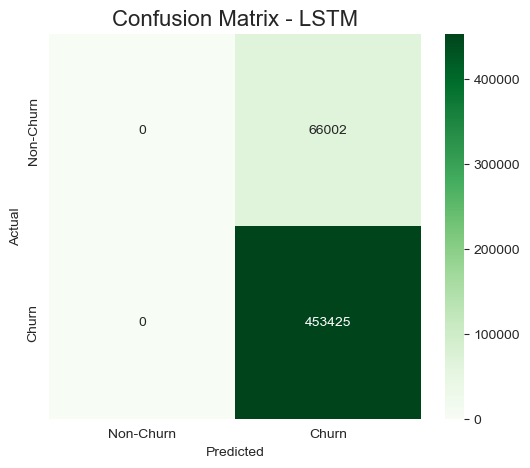

In [8]:
# --- CELL 8: HU·∫§N LUY·ªÜN V√Ä ƒê√ÅNH GI√Å LSTM V·ªöI PYTORCH ---

X_train_tensor = torch.tensor(X_train_seq.astype(np.float32))
y_train_tensor = torch.tensor(y_train_seq.astype(np.float32)).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_seq.astype(np.float32))
y_test_tensor = torch.tensor(y_test_seq.astype(np.float32)).unsqueeze(1)

class ChurnDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(ChurnDataset(X_train_tensor, y_train_tensor), batch_size=256, shuffle=True)
test_loader = DataLoader(ChurnDataset(X_test_tensor, y_test_tensor), batch_size=256, shuffle=False)

class LSTMChurn(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.3):
        super(LSTMChurn, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return self.sigmoid(out)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_lstm = LSTMChurn(input_size=len(features), hidden_size=64).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

print(f"B·∫Øt ƒë·∫ßu hu·∫•n luy·ªán LSTM tr√™n thi·∫øt b·ªã: {device.upper()}...")
num_epochs = 5
for epoch in range(num_epochs):
    model_lstm.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model_lstm(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

print("\nƒê√°nh gi√° m√¥ h√¨nh LSTM...")
model_lstm.eval()
all_probs_lstm, all_labels_lstm = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model_lstm(batch_X.to(device))
        all_probs_lstm.extend(outputs.cpu().numpy())
        all_labels_lstm.extend(batch_y.cpu().numpy())

y_proba_lstm = np.array(all_probs_lstm)
y_pred_lstm = (y_proba_lstm > 0.5).astype(int)
y_true_lstm = np.array(all_labels_lstm)

print("\n--- üìä K·∫æT QU·∫¢ LSTM ---")
print(classification_report(y_true_lstm, y_pred_lstm, target_names=['Non-Churn (0)', 'Churn (1)']))
roc_auc_lstm = roc_auc_score(y_true_lstm, y_proba_lstm)
f1_lstm = f1_score(y_true_lstm, y_pred_lstm)
print(f"üöÄ F1-Score: {f1_lstm:.4f}")
print(f"üöÄ ROC AUC Score: {roc_auc_lstm:.4f}")

plt.figure(figsize=(6, 5))
cm_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
plt.title('Confusion Matrix - LSTM', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Chu·∫©n b·ªã d·ªØ li·ªáu cho N-HiTS...
M·ªói user c·∫ßn c√≥ √≠t nh·∫•t 5 th√°ng d·ªØ li·ªáu trong t·∫≠p train ƒë·ªÉ ƒë∆∞·ª£c hu·∫•n luy·ªán.


Seed set to 42


T·ªïng s·ªë user trong t·∫≠p train ban ƒë·∫ßu: 11839964
S·ªë user c√≥ ƒë·ªß d·ªØ li·ªáu ƒë·ªÉ hu·∫•n luy·ªán: 436610

B·∫Øt ƒë·∫ßu hu·∫•n luy·ªán N-HiTS (ch·∫ø ƒë·ªô t·ªëi ∆∞u)...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.499     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.


‚úÖ Hu·∫•n luy·ªán N-HiTS ho√†n t·∫•t.

B·∫Øt ƒë·∫ßu d·ª± b√°o...


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]


--- üìä K·∫æT QU·∫¢ N-HITS (CHO B√ÄI TO√ÅN CHURN) ---
               precision    recall  f1-score   support

Non-Churn (0)       0.33      0.12      0.17     48236
    Churn (1)       0.86      0.96      0.91    276437

     accuracy                           0.83    324673
    macro avg       0.60      0.54      0.54    324673
 weighted avg       0.78      0.83      0.80    324673

üöÄ F1-Score: 0.9075
üöÄ ROC AUC Score: 0.4037


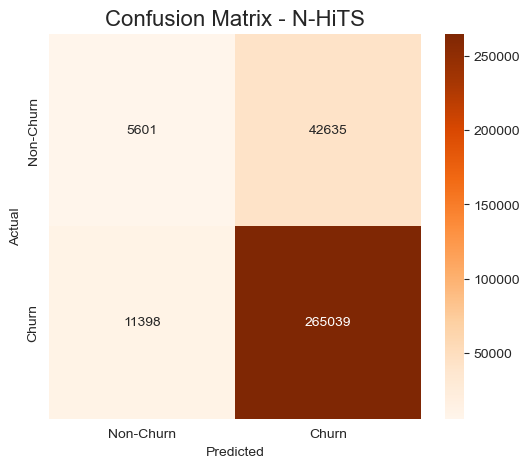

In [16]:
# --- CELL 9 (PHI√äN B·∫¢N HU·∫§N LUY·ªÜN T·ªêI ∆ØU) ---
# HU·∫§N LUY·ªÜN V√Ä ƒê√ÅNH GI√Å N-HITS V·ªöI HI·ªÜU SU·∫§T T·ªêT NH·∫§T

print("Chu·∫©n b·ªã d·ªØ li·ªáu cho N-HiTS...")

df_nhits_data = df_processed[['user_id', 'month', 'purchase_count', 'churn']].copy()
df_nhits_data.columns = ['unique_id', 'ds', 'y', 'churn']

train_nhits_df_full = df_nhits_data[df_nhits_data['ds'] < last_month]
test_nhits_df = df_nhits_data[df_nhits_data['ds'] == last_month]

# === B∆Ø·ªöC 1: C·∫§U H√åNH C√ÅC THAM S·ªê QUAN TR·ªåNG ===
# Ch√∫ng ta s·∫Ω th·ª≠ v·ªõi input_size = 3, t·ª©c l√† d√πng 3 th√°ng l·ªãch s·ª≠
INPUT_SIZE = 3
H = 1 # D·ª± b√°o 1 th√°ng t·ªõi
VAL_SIZE = 1 # D√πng 1 th√°ng cu·ªëi ƒë·ªÉ l√†m t·∫≠p validation

# T√≠nh to√°n s·ªë th√°ng t·ªëi thi·ªÉu m√† m·ªôt user c·∫ßn c√≥
MIN_LEN = INPUT_SIZE + H + VAL_SIZE 
print(f"M·ªói user c·∫ßn c√≥ √≠t nh·∫•t {MIN_LEN} th√°ng d·ªØ li·ªáu trong t·∫≠p train ƒë·ªÉ ƒë∆∞·ª£c hu·∫•n luy·ªán.")


# === B∆Ø·ªöC 2: L·ªåC RA NH·ªÆNG USER C√ì ƒê·ª¶ D·ªÆ LI·ªÜU ===
user_lengths = train_nhits_df_full.groupby('unique_id').size()
valid_users = user_lengths[user_lengths >= MIN_LEN].index
train_nhits_df = train_nhits_df_full[train_nhits_df_full['unique_id'].isin(valid_users)]

print(f"T·ªïng s·ªë user trong t·∫≠p train ban ƒë·∫ßu: {train_nhits_df_full['unique_id'].nunique()}")
print(f"S·ªë user c√≥ ƒë·ªß d·ªØ li·ªáu ƒë·ªÉ hu·∫•n luy·ªán: {len(valid_users)}")


# === B∆Ø·ªöC 3: C·∫§U H√åNH M√î H√åNH N-HITS ƒê·ªÇ T·ªêI ∆ØU HI·ªÜU SU·∫§T ===
# B·∫≠t l·∫°i Early Stopping v√† tinh ch·ªânh c√°c tham s·ªë kh√°c
# B·∫°n c√≥ th·ªÉ th·ª≠ nghi·ªám thay ƒë·ªïi c√°c gi√° tr·ªã n√†y ƒë·ªÉ t√¨m k·∫øt qu·∫£ t·ªët h∆°n
model_nhits = NHITS(
    h=H,
    input_size=INPUT_SIZE,
    max_steps=1000,              # TƒÉng s·ªë b∆∞·ªõc t·ªëi ƒëa
    learning_rate=0.001,           # T·ªëc ƒë·ªô h·ªçc
    n_pool_kernel_size=[2, 2, 2],  # C·∫•u tr√∫c c·ªßa c√°c kh·ªëi pooling
    n_freq_downsample=[2, 2, 1],   # C·∫•u tr√∫c c·ªßa c√°c kh·ªëi downsampling t·∫ßn s·ªë
    early_stop_patience_steps=10, # B·∫≠t l·∫°i early stopping v·ªõi patience = 10
    random_seed=42
)

fcst = NeuralForecast(models=[model_nhits], freq='MS')


# === B∆Ø·ªöC 4: HU·∫§N LUY·ªÜN M√î H√åNH ===
print("\nB·∫Øt ƒë·∫ßu hu·∫•n luy·ªán N-HiTS (ch·∫ø ƒë·ªô t·ªëi ∆∞u)...")
# Th√™m val_size=VAL_SIZE ƒë·ªÉ b·∫≠t validation set
fcst.fit(df=train_nhits_df[['unique_id', 'ds', 'y']], val_size=VAL_SIZE)
print("‚úÖ Hu·∫•n luy·ªán N-HiTS ho√†n t·∫•t.")


# === B∆Ø·ªöC 5: D·ª∞ B√ÅO V√Ä ƒê√ÅNH GI√Å ===
print("\nB·∫Øt ƒë·∫ßu d·ª± b√°o...")
predictions_nhits = fcst.predict()
predictions_nhits = predictions_nhits.reset_index()

# L·ªçc t·∫≠p test ch·ªâ v·ªõi nh·ªØng user ƒë√£ ƒë∆∞·ª£c l·ªçc ƒë·ªÉ hu·∫•n luy·ªán (ƒë·ªÉ so s√°nh c√¥ng b·∫±ng)
test_nhits_df_filtered = test_nhits_df[test_nhits_df['unique_id'].isin(valid_users)]

merged_test_nhits = pd.merge(test_nhits_df_filtered, predictions_nhits, on='unique_id', how='left')
merged_test_nhits['NHITS'] = merged_test_nhits['NHITS'].fillna(0)

# G√°n c·ªôt d·ª± ƒëo√°n v√†o DataFrame ƒë·ªÉ c√°c cell sau c√≥ th·ªÉ s·ª≠ d·ª•ng
y_pred_nhits = (merged_test_nhits['NHITS'] <= 0.5).astype(int)
merged_test_nhits['churn_pred_nhits'] = y_pred_nhits


# === B∆Ø·ªöC 6: B√ÅO C√ÅO K·∫æT QU·∫¢ ===
print("\n--- üìä K·∫æT QU·∫¢ N-HITS (CHO B√ÄI TO√ÅN CHURN) ---")
if not merged_test_nhits.empty and 'churn' in merged_test_nhits.columns:
    y_true_nhits = merged_test_nhits['churn']
    y_proba_nhits = 1 / (1 + np.exp(-merged_test_nhits['NHITS']))
    
    print(classification_report(y_true_nhits, y_pred_nhits, target_names=['Non-Churn (0)', 'Churn (1)']))
    roc_auc_nhits = roc_auc_score(y_true_nhits, y_proba_nhits)
    f1_nhits = f1_score(y_true_nhits, y_pred_nhits)
    print(f"üöÄ F1-Score: {f1_nhits:.4f}")
    print(f"üöÄ ROC AUC Score: {roc_auc_nhits:.4f}")

    plt.figure(figsize=(6, 5))
    cm_nhits = confusion_matrix(y_true_nhits, y_pred_nhits)
    sns.heatmap(cm_nhits, annot=True, fmt='d', cmap='Oranges', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
    plt.title('Confusion Matrix - N-HiTS', fontsize=16)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("T·∫≠p test cho N-HiTS r·ªóng ho·∫∑c c√≥ l·ªói, kh√¥ng th·ªÉ t·∫°o b√°o c√°o.")
    roc_auc_nhits, f1_nhits = 0.5, 0.0

T·ªïng h·ª£p k·∫øt qu·∫£ t·ª´ 3 m√¥ h√¨nh...

B·∫£ng so s√°nh hi·ªáu su·∫•t:
     Model   ROC AUC  F1-Score (Churn)
0  XGBoost  0.754006          0.846920
1     LSTM  0.659644          0.932156
2   N-HiTS  0.403688          0.907495


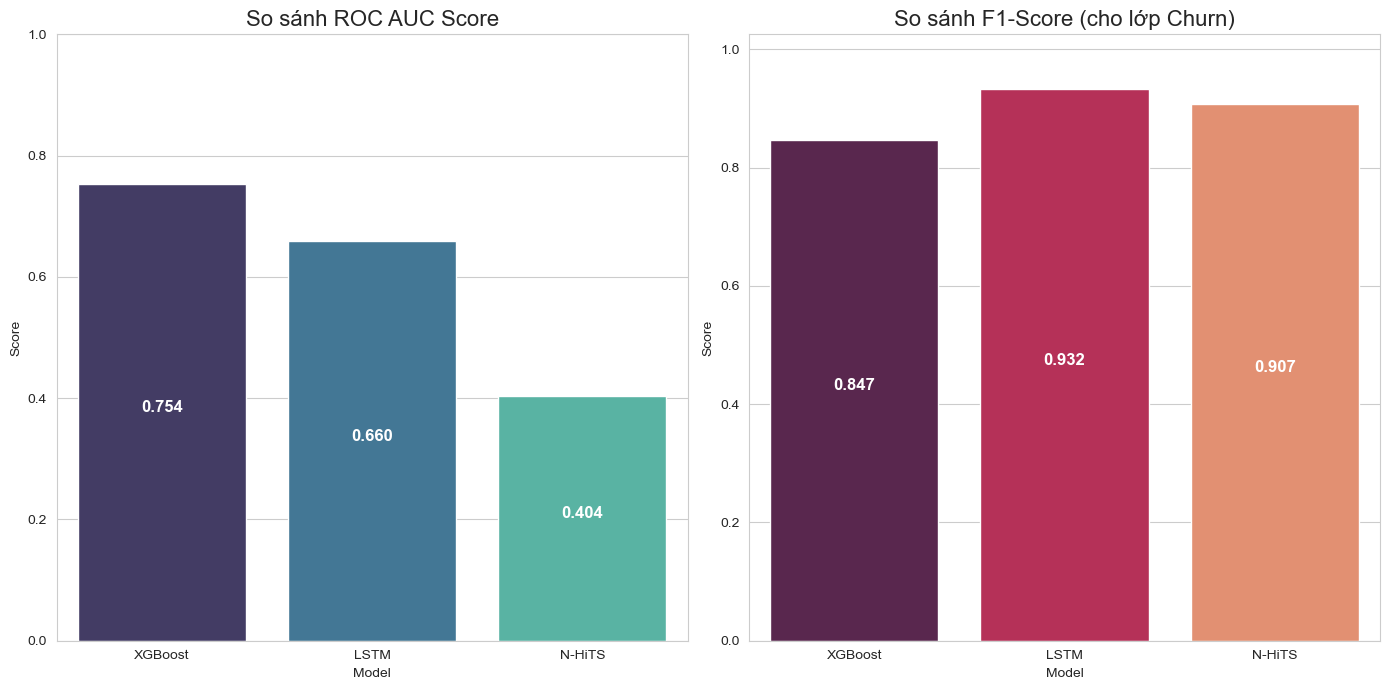

In [17]:
# --- CELL 10: T·ªîNG K·∫æT V√Ä SO S√ÅNH K·∫æT QU·∫¢ ---

print("T·ªïng h·ª£p k·∫øt qu·∫£ t·ª´ 3 m√¥ h√¨nh...")

results = pd.DataFrame({
    'Model': ['XGBoost', 'LSTM', 'N-HiTS'],
    'ROC AUC': [roc_auc_xgb, roc_auc_lstm, roc_auc_nhits],
    'F1-Score (Churn)': [f1_xgb, f1_lstm, f1_nhits]
})

results = results.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)
print("\nB·∫£ng so s√°nh hi·ªáu su·∫•t:")
print(results)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=results, x='Model', y='ROC AUC', palette='mako')
plt.title('So s√°nh ROC AUC Score', fontsize=16)
plt.ylabel('Score')
plt.ylim(0, max(results['ROC AUC'].max() * 1.1, 1.0))
for i, row in results.iterrows():
    ax1.text(i, row['ROC AUC'] / 2, f"{row['ROC AUC']:.3f}", color='white', ha="center", fontsize=12, weight='bold')

plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=results, x='Model', y='F1-Score (Churn)', palette='rocket')
plt.title('So s√°nh F1-Score (cho l·ªõp Churn)', fontsize=16)
plt.ylabel('Score')
plt.ylim(0, max(results['F1-Score (Churn)'].max() * 1.1, 1.0))
for i, row in results.iterrows():
    ax2.text(i, row['F1-Score (Churn)'] / 2, f"{row['F1-Score (Churn)']:.3f}", color='white', ha="center", fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

B·∫Øt ƒë·∫ßu t·ªïng h·ª£p k·∫øt qu·∫£ ƒë·ªÉ tr·ª±c quan h√≥a theo chu·ªói th·ªùi gian...
T·∫°o sequence k√®m theo th√°ng cho t·ª´ng user...



ƒê√£ t√≠nh t·ª∑ l·ªá churn th·ª±c t·∫ø.
ƒê√£ t√≠nh t·ª∑ l·ªá churn d·ª± b√°o c·ªßa XGBoost.
ƒê√£ t√≠nh t·ª∑ l·ªá churn d·ª± b√°o c·ªßa LSTM.
ƒê√£ t√≠nh t·ª∑ l·ªá churn d·ª± b√°o c·ªßa N-HiTS.

‚úÖ Ho√†n t·∫•t! ƒêang hi·ªÉn th·ªã bi·ªÉu ƒë·ªì so s√°nh cu·ªëi c√πng.


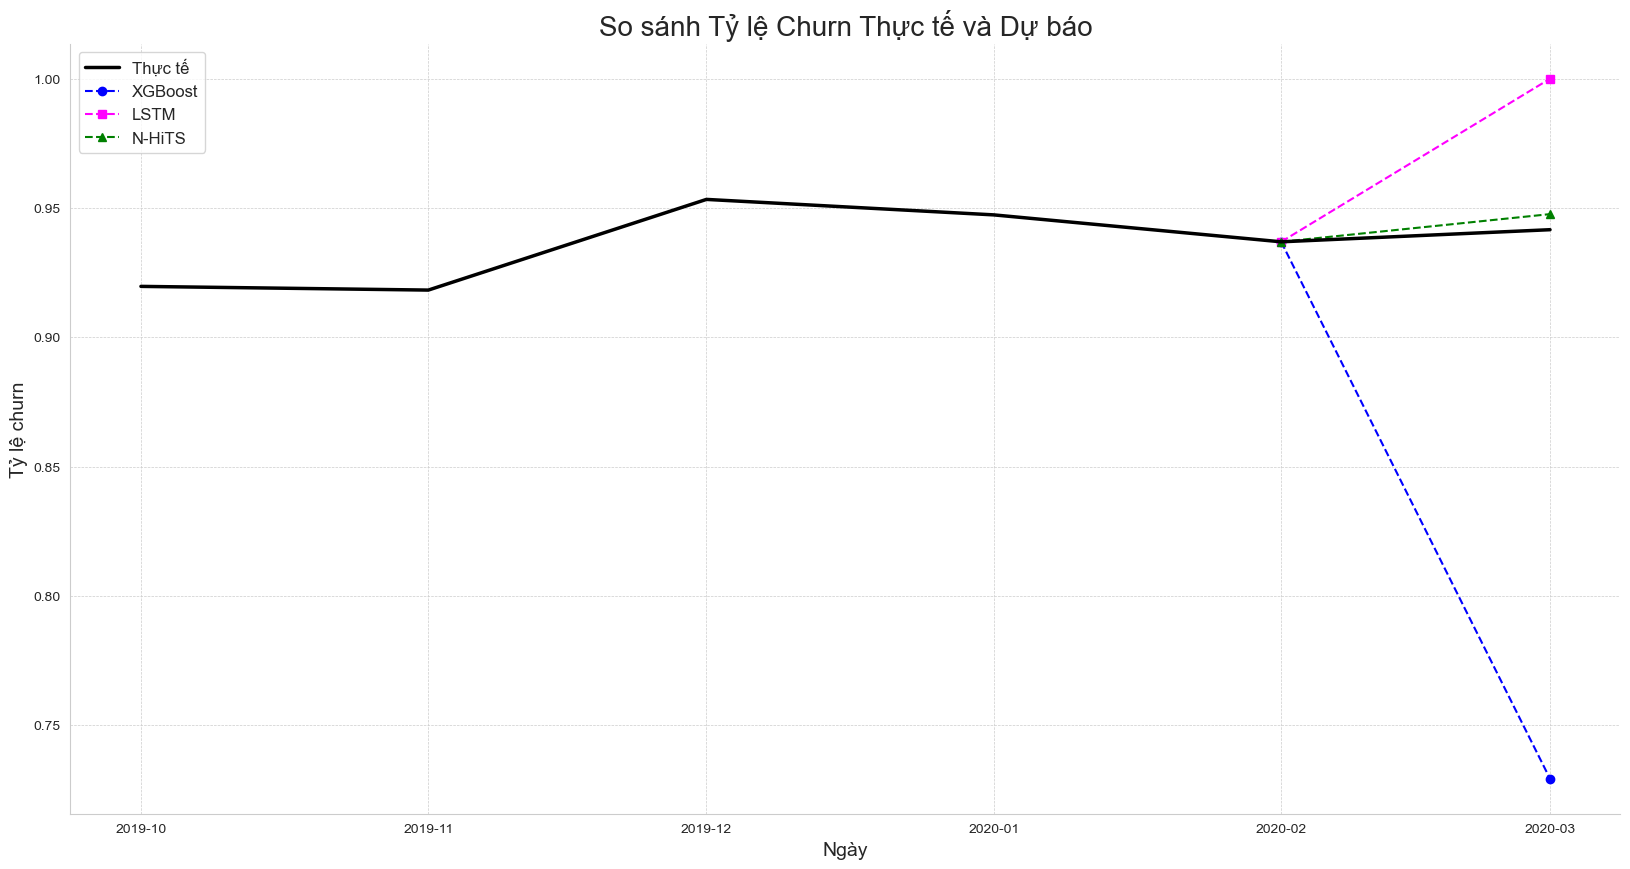

In [18]:
# --- CELL 11 (PHI√äN B·∫¢N AN TO√ÄN V√Ä CH√çNH X√ÅC) ---
# TR·ª∞C QUAN H√ìA SO S√ÅNH CU·ªêI C√ôNG THEO TH·ªúI GIAN

print("B·∫Øt ƒë·∫ßu t·ªïng h·ª£p k·∫øt qu·∫£ ƒë·ªÉ tr·ª±c quan h√≥a theo chu·ªói th·ªùi gian...")

def create_sequences_with_date(df, features, target, sequence_length=3):
    X_seq, y_seq, month_seq = [], [], []
    user_groups = df.groupby('user_id')
    print("T·∫°o sequence k√®m theo th√°ng cho t·ª´ng user...")
    for user_id, group in tqdm(user_groups):
        if len(group) > sequence_length:
            data = group[features].values; labels = group[target].values; months = group['month'].values
            for i in range(len(data) - sequence_length):
                X_seq.append(data[i:i + sequence_length]); y_seq.append(labels[i + sequence_length]); month_seq.append(months[i + sequence_length])
    return np.array(X_seq), np.array(y_seq), np.array(month_seq)

# S·ª¨A L·ªñI: D√πng df_processed thay v√¨ df_final
X_all_seq, y_all_seq, month_all_seq = create_sequences_with_date(df_processed, features, target, SEQUENCE_LENGTH)

# --- T√≠nh to√°n t·ª∑ l·ªá churn cho t·ª´ng m√¥ h√¨nh ---
actual_churn_rate = df_processed.groupby('month')['churn'].mean().reset_index()
actual_churn_rate.rename(columns={'churn': 'Th·ª±c t·∫ø'}, inplace=True)
print("\nƒê√£ t√≠nh t·ª∑ l·ªá churn th·ª±c t·∫ø.")

xgb_results_df = test_df[['month']].copy()
xgb_results_df['XGBoost'] = y_pred_xgb
xgb_predicted_rate = xgb_results_df.groupby('month')['XGBoost'].mean().reset_index()
print("ƒê√£ t√≠nh t·ª∑ l·ªá churn d·ª± b√°o c·ªßa XGBoost.")

test_indices = np.where(pd.to_datetime(month_all_seq) == last_month)[0]
if len(test_indices) > 0:
    X_lstm_final_test = torch.tensor(X_all_seq[test_indices].astype(np.float32)).to(device)
    model_lstm.eval()
    with torch.no_grad():
        lstm_preds_for_viz = model_lstm(X_lstm_final_test).cpu().numpy()
    lstm_results_df = pd.DataFrame({'month': last_month, 'LSTM': (lstm_preds_for_viz.flatten() > 0.5).astype(int)})
    lstm_predicted_rate = lstm_results_df.groupby('month')['LSTM'].mean().reset_index()
    print("ƒê√£ t√≠nh t·ª∑ l·ªá churn d·ª± b√°o c·ªßa LSTM.")
else:
    lstm_predicted_rate = pd.DataFrame(columns=['month', 'LSTM'])
    print("C·∫£nh b√°o: Kh√¥ng c√≥ ƒë·ªß d·ªØ li·ªáu ƒë·ªÉ t·∫°o sequence cho LSTM tr√™n t·∫≠p test th·ªùi gian.")

# S·ª¨A L·ªñI: Truy c·∫≠p ƒë√∫ng t√™n c·ªôt 'ds_x' v√† 'churn_pred_nhits'
if 'ds_x' in merged_test_nhits.columns and 'churn_pred_nhits' in merged_test_nhits.columns and not merged_test_nhits.empty:
    nhits_results_df = merged_test_nhits[['ds_x', 'churn_pred_nhits']].copy()
    nhits_results_df.rename(columns={'ds_x': 'month', 'churn_pred_nhits': 'N-HiTS'}, inplace=True)
    nhits_predicted_rate = nhits_results_df.groupby('month')['N-HiTS'].mean().reset_index()
    print("ƒê√£ t√≠nh t·ª∑ l·ªá churn d·ª± b√°o c·ªßa N-HiTS.")
else:
    nhits_predicted_rate = pd.DataFrame(columns=['month', 'N-HiTS'])
    print("C·∫£nh b√°o: Kh√¥ng th·ªÉ t√≠nh to√°n t·ª∑ l·ªá churn d·ª± b√°o cho N-HiTS.")

# --- G·ªôp t·∫•t c·∫£ d·ªØ li·ªáu v√† v·∫Ω bi·ªÉu ƒë·ªì ---
final_plot_df = actual_churn_rate.set_index('month')
plot_data_list = [xgb_predicted_rate, lstm_predicted_rate, nhits_predicted_rate]
for df in plot_data_list:
    if not df.empty:
        df = df.set_index('month')
        final_plot_df = final_plot_df.merge(df, on='month', how='left')

if len(final_plot_df) > 1 and last_month in final_plot_df.index:
    last_actual_month_index = final_plot_df.index.get_loc(last_month) - 1
    if last_actual_month_index >= 0:
        last_actual_value = final_plot_df['Th·ª±c t·∫ø'].iloc[last_actual_month_index]
        for model_col in ['XGBoost', 'LSTM', 'N-HiTS']:
            if model_col in final_plot_df.columns:
                final_plot_df.loc[final_plot_df.index[last_actual_month_index], model_col] = last_actual_value

plt.figure(figsize=(20, 10))
plt.plot(final_plot_df.index, final_plot_df['Th·ª±c t·∫ø'], label='Th·ª±c t·∫ø', color='black', linewidth=2.5, zorder=5)
for model_col, color, marker in zip(['XGBoost', 'LSTM', 'N-HiTS'], ['blue', 'magenta', 'green'], ['o', 's', '^']):
    if model_col in final_plot_df.columns:
         plt.plot(final_plot_df.index, final_plot_df[model_col], label=model_col, color=color, marker=marker, linestyle='--')

plt.title('So s√°nh T·ª∑ l·ªá Churn Th·ª±c t·∫ø v√† D·ª± b√°o', fontsize=20)
plt.xlabel('Ng√†y', fontsize=14); plt.ylabel('T·ª∑ l·ªá churn', fontsize=14)
plt.legend(fontsize=12, loc='best'); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().spines['top'].set_visible(False); plt.gca().spines['right'].set_visible(False)
print("\n‚úÖ Ho√†n t·∫•t! ƒêang hi·ªÉn th·ªã bi·ªÉu ƒë·ªì so s√°nh cu·ªëi c√πng.")
plt.show()